In [122]:
import re
import cv2
import imutils
import requests
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

import pytesseract
from pytesseract import Output

import googletrans
from googletrans import Translator

from PIL import Image, ImageFont, ImageDraw
from timm.models.hub import download_cached_file
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours

plt.style.use('seaborn')
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
MODEL_URL = "https://github.com/Boram3J/image-editing/releases/download/inpainting/big-lama-344c77bb.pt"
img_url = 'https://user-images.githubusercontent.com/69428232/148330274-237d9b23-4a79-4416-8ef1-bb7b2b52edc4.jpg'
device = "cuda"

In [123]:
def plt_imshow(title='image', img=None, figsize=(10, 8)):
    """이미지 확인"""
    plt.figure(figsize=figsize)
    rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(rgbImg)
    plt.title(title)
    plt.xticks([]), plt.yticks([])
    plt.show()


def make_scan_image(image,
                    width,
                    ksize=(5, 5),
                    min_threshold=75,
                    max_threshold=200):
    """Scan 이미지로 변환"""
    org_image = image.copy()
    image = imutils.resize(image, width=width)
    ratio = org_image.shape[1] / float(image.shape[1])

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, ksize, 0)
    edged = cv2.Canny(blurred, min_threshold, max_threshold)

    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    findCnt = None

    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        if len(approx) == 4:
            findCnt = approx
            break

    if findCnt is None:
        raise Exception(("Could not find outline."))

    transform_image = four_point_transform(org_image,
                                           findCnt.reshape(4, 2) * ratio)

    return transform_image


def load_model(device="cpu", progress=True):
    model_path = download_cached_file(MODEL_URL, progress=progress)
    model = torch.jit.load(model_path, map_location="cpu")
    model.to(device)
    model.eval()

    return model

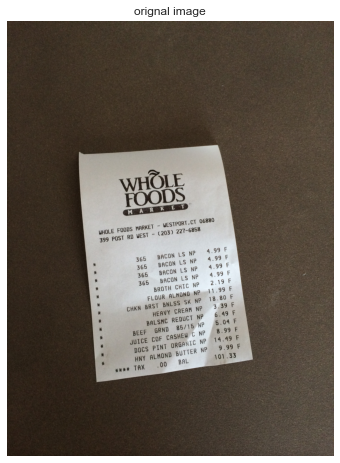

In [124]:
image_nparray = np.asarray(bytearray(requests.get(img_url).content),
                           dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
plt_imshow("orignal image", org_image)

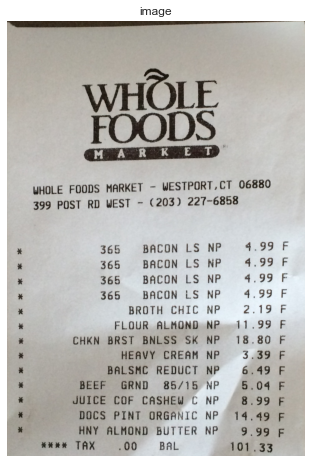

In [125]:
receipt_image = make_scan_image(org_image,
                                width=200,
                                ksize=(3, 3),
                                min_threshold=20,
                                max_threshold=100)
plt_imshow(img=receipt_image)

In [126]:
results = pytesseract.image_to_data(receipt_image, output_type=Output.DICT)

In [127]:
translator = Translator()

In [128]:
fontpath = "C:/Windows/Fonts/Malgun.TTF"
font = ImageFont.truetype(fontpath, 20)

In [129]:
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

In [136]:
torch.manual_seed(1)
model = load_model(device=device)

In [154]:
img = Image.fromarray(receipt_image)
img = img.resize((1176, 1720))
draw = ImageDraw.Draw(img)

temp = 0
for i in range(0, len(results["text"])):
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]

    text = results["text"][i]
    conf = float(results["conf"][i])

    if conf > 50.:
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        if text.isalpha():
            trans = translator.translate(text, src='en', dest='ko')
            text = trans.text

        draw.rectangle([(x, y), (x + w, y + h)], (0, 0, 0))

        img = [transform(img)]
        inp = torch.stack(img, dim=0).to(device)
        msk = inp[:, :1] < torch.finfo(inp.dtype).eps

        with torch.inference_mode():
            out = model(inp, msk.long()).cuda()
            img = [to_pil_image(_) for _ in out]
            img = img[0]
            
        draw = ImageDraw.Draw(img)
        draw.text((x, y), text, font=font, fill=(0, 0, 0))
        
        temp += 1
        if temp == 5:
            break

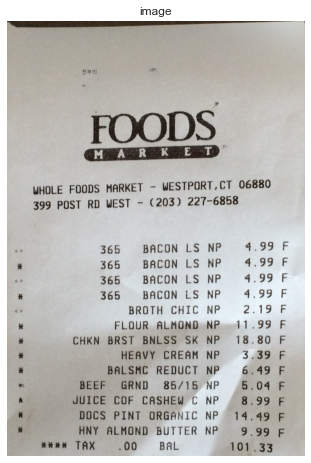

In [155]:
img = np.array(img)
plt_imshow(img=img)